In [1]:
import os
import pickle
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd


In [2]:
# DATA PARAMETERS

survey = "CORALIE" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 4400 # minimum wavelength of the data
max_wv = 4600 # maximum wavelength of the data
spec_dir = r"C:\Users\kentb\Desktop\PDM\data\Coralie14\spectra\RCru_Coralie14" # directory of the spectrum
rv_dir = r"C:\Users\kentb\Desktop\PDM\data\Coralie14\RV\RCru_CORALIE14.csv" # directory of the RVs
results_dir = r"C:\Users\kentb\Desktop\PDM\data\products\Coralie14\RCru" # directory of the results

In [10]:
obs_data = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,
                        target_visits_lib=spec_dir,find_beggining=True)
df = pd.read_csv(rv_dir)
rv = df.rv.astype(float).values
e_rv = df.rv_err.astype(float).values
times = df.bjd.astype(float).values
times = times+2400000# - int(min(obs_data.time_series.times))

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\data\Coralie14\spectra\RCru_Coralie14
Selected directory: C:\Users\kentb\Desktop\PDM\data\Coralie14\spectra\RCru_Coralie14


In [16]:
print(len(times),len(obs_data.time_series.times))
print(np.sort(times), '\n',np.sort(obs_data.time_series.times))

218 95
[8.20278000e-01 2.82527000e+00 3.82639500e+00 5.84892400e+00
 7.79006100e+00 1.08594280e+01 1.27874520e+01 6.67149510e+01
 6.87211090e+01 6.96348710e+01 7.06626650e+01 7.27951980e+01
 7.28347240e+01 1.13560739e+02 1.14663013e+02 1.15554825e+02
 1.16647017e+02 1.17681661e+02 1.19587453e+02 1.20508473e+02
 1.21676515e+02 1.22679881e+02 1.24703347e+02 1.25706919e+02
 3.64774955e+02 3.65824242e+02 3.66858458e+02 3.67818747e+02
 3.91803949e+02 3.92801047e+02 3.93797752e+02 3.94822872e+02
 3.95890564e+02 4.21654472e+02 4.23735486e+02 4.43646724e+02
 4.44706201e+02 4.45634759e+02 4.46868567e+02 4.47609490e+02
 4.48850206e+02 4.49690633e+02 4.50879007e+02 4.51854065e+02
 4.52841391e+02 4.53564867e+02 4.54590144e+02 4.55561540e+02
 4.56731412e+02 4.57579298e+02 4.83706002e+02 4.84601202e+02
 4.85569490e+02 4.92597523e+02 4.93634598e+02 4.94631071e+02
 4.95454295e+02 7.17742707e+02 7.17817572e+02 7.18731823e+02
 7.18737263e+02 7.18781791e+02 7.18828969e+02 7.18861540e+02
 7.19750743e+02 7

In [11]:
# Rearrange the RVs with the spectra

obs_data.rearrange_time_series(rv=rv, times=times)

In [14]:
print(type(obs_data.time_series.times))

<class 'list'>


In [15]:
obs_data.time_series.times = [i-int(min(times)) for i in obs_data.time_series.times]
times = times -int(min(times))

In [17]:
# Preprocess the spectra

for i in obs_data.time_series.vals:
    i = i.SpecPreProccess()

In [43]:
# PERIODOGRAM PARAMETERS

baseline = int(obs_data.time_series.times[-1])
min_freq = 1/600 # Or maybe 1/2/baseline to be sure but let's test it that way.
max_freq = 1 # we don't expect more than one pulsation every two day so should be alright.
freq_range = (min_freq, max_freq) # frequency range of the periodograms
points_per_peak = 5
periodogram_grid_resolution = points_per_peak*max_freq*baseline # frequency resolution of the periodograms

In [38]:
print("Baseline: ", baseline)

Baseline:  3642


In [44]:
# Choosing frequency range and frequency resolution for the periodograms.
obs_data.initialize_periodicity_detector(freq_range=freq_range,
                                        periodogram_grid_resolution=periodogram_grid_resolution)

In [45]:
obs_data.periodicity_detector.calc_GLS()

print("GLS done", flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shape")

print("Shape done",flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shift")

print("Shift done",flush=True)

# file = open(os.path.join(results_dir, f"{spec_dir.rsplit('/',maxsplit=1)[-1]}_{str(min_wv)}_{str(max_wv)}.pkl"), 'wb')
# pickle.dump(obs_data, file)
# file.close()

GLS done
Shape done
Shift done


In [46]:
obs_data.periodicity_detector.period_truth = [5.82575]

Relative error on period:  0.00013687966153741522
Max shape peak power:  0.7848850783292425
Max shift peak power:  0.28898107387932587
Ratio of max shape to max shift:  2.7160431920084798


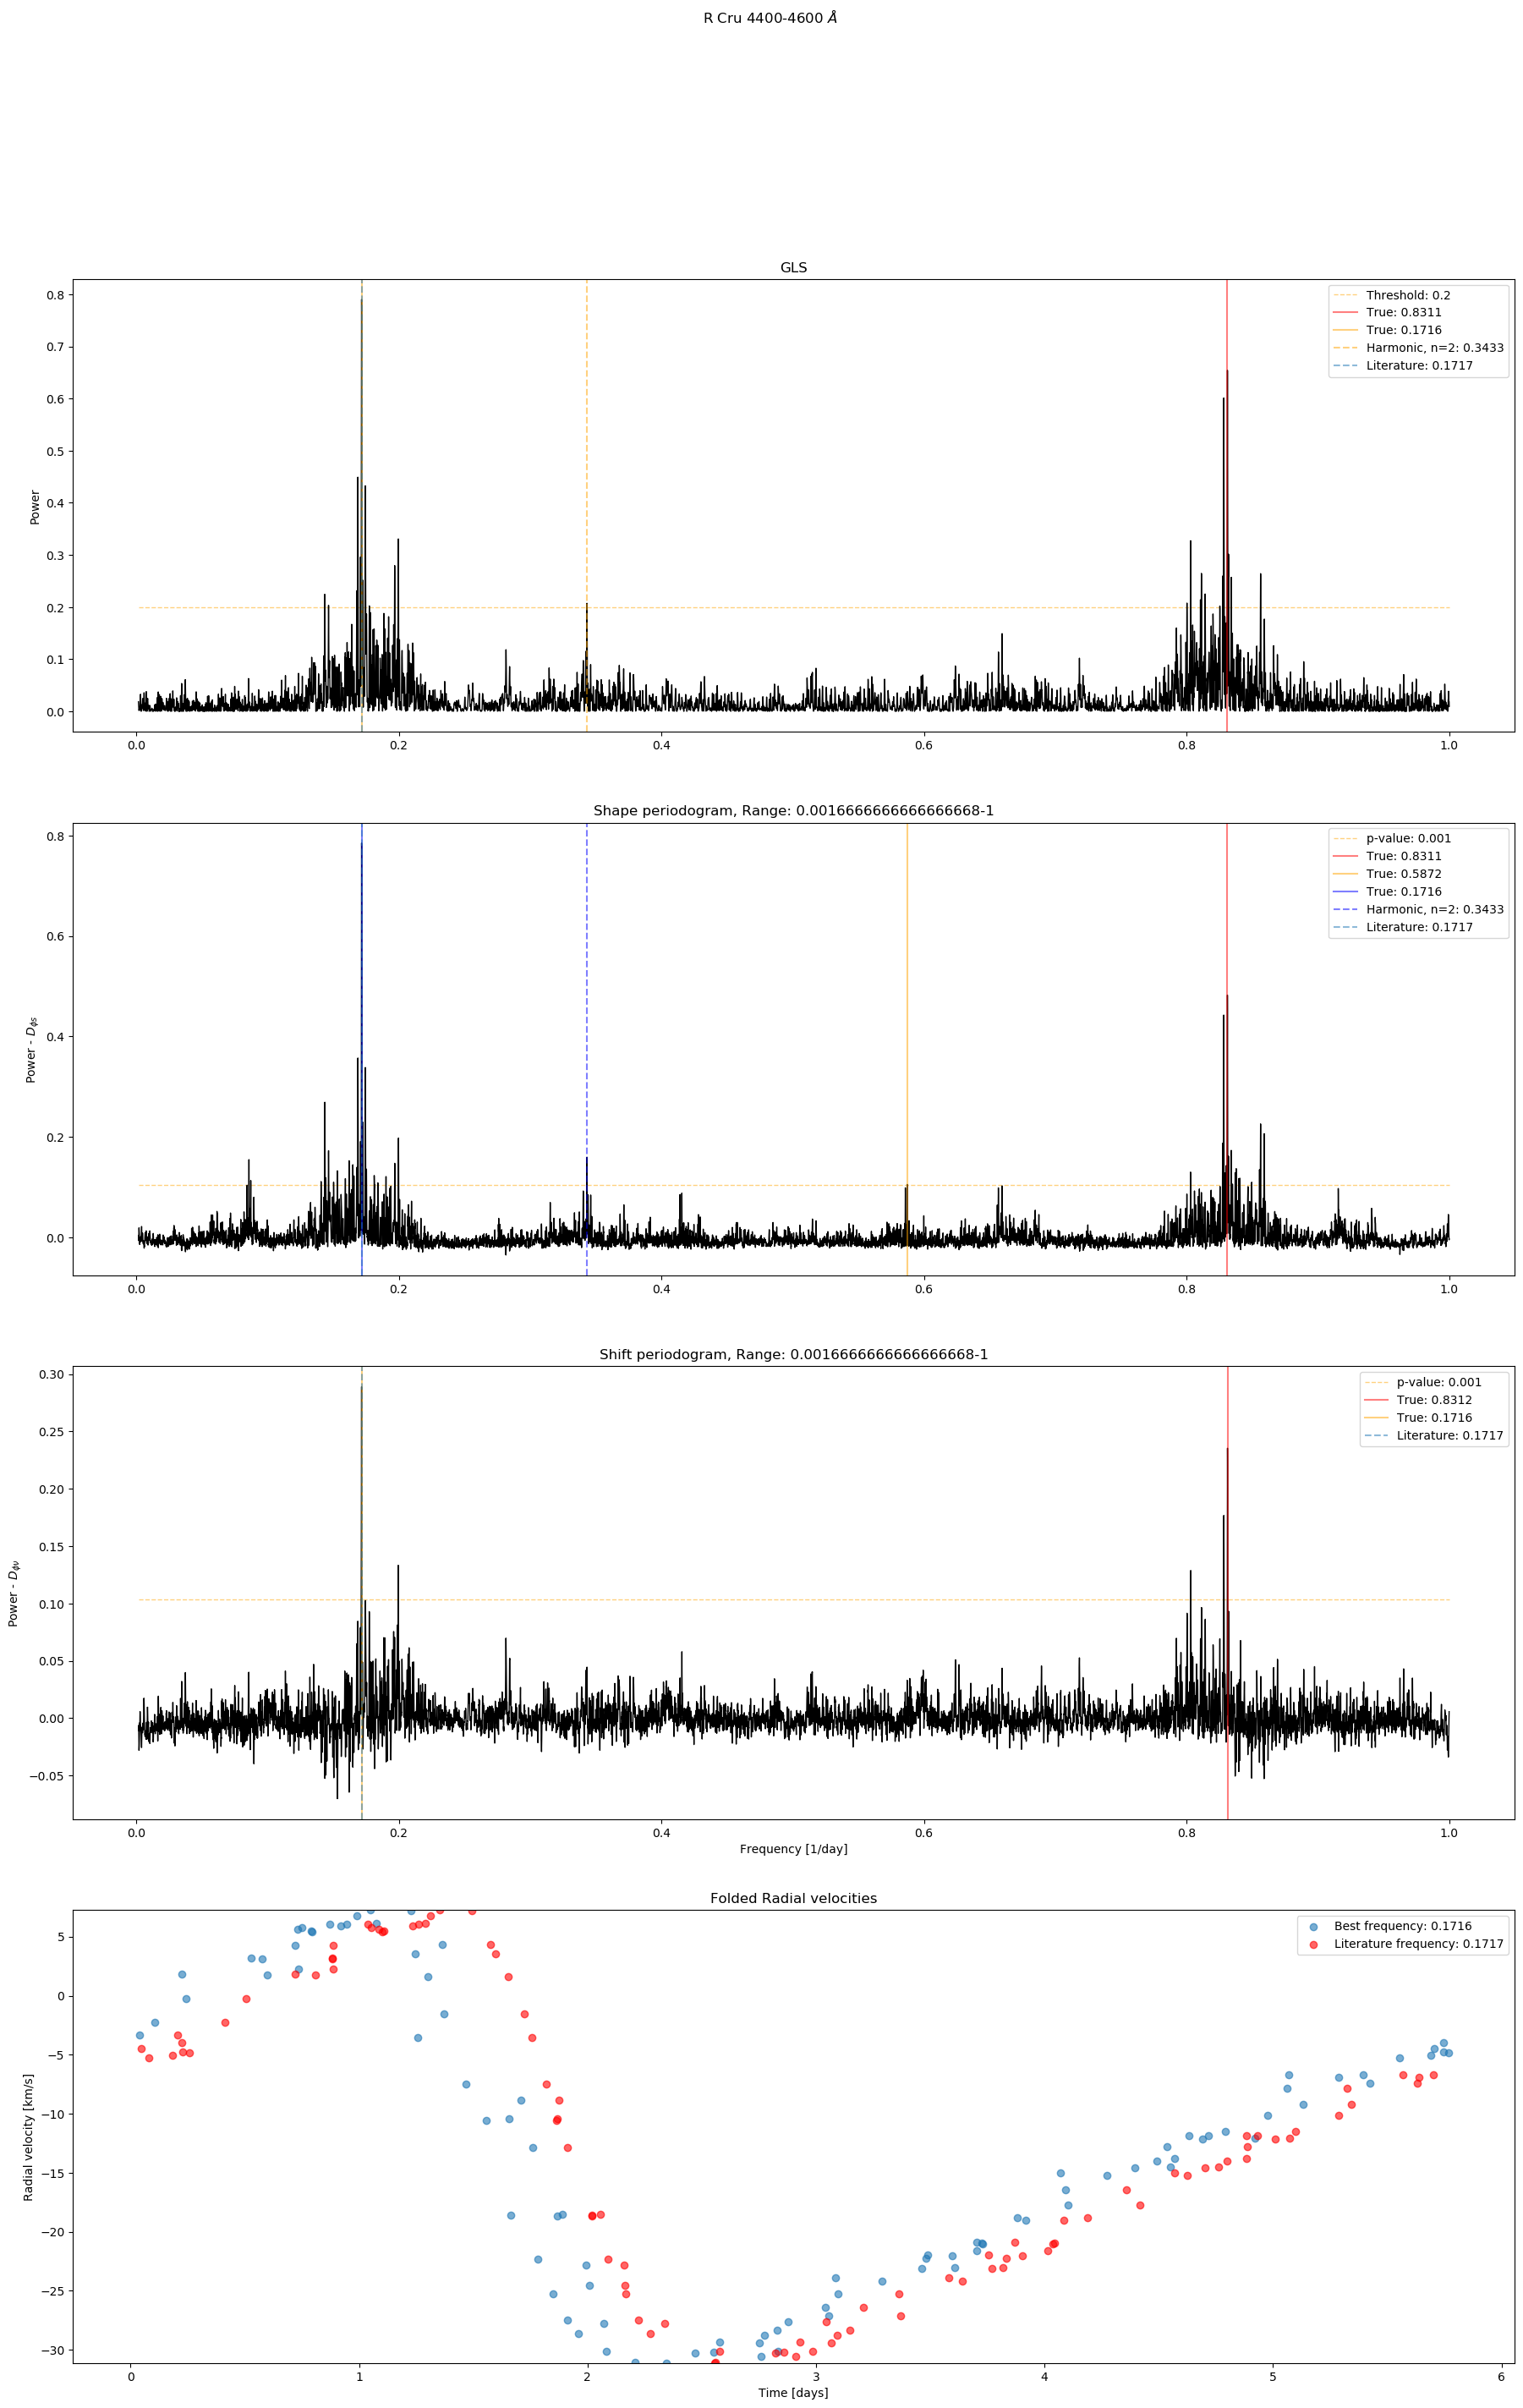

In [47]:
# Plotting the periodograms

obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-3], plot_rv=True,title=r"R Cru 4400-4600 $\AA$", log_scale=False, plot_peaks=True)

RCru seems to be a double mode with frequencies of 0.172 and 0.831.